## Load data from Google drive

In [86]:
# load data from Google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


We will use train and test images and .csv inside the following folder.

In [87]:
!ls /content/drive/MyDrive/data/

sample_submission_v2.csv    test-jpg.tar.7z	      train-jpg.tar.7z
test-jpg		    test_v2_file_mapping.csv  train_v2.csv
test-jpg-additional.tar.7z  train-jpg


## Import libraries

In [105]:
!pip install iterative-stratification

In [106]:
import numpy as np
import pandas as pd
import os
import gc
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from collections import Counter

from sklearn.preprocessing import MultiLabelBinarizer
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [74]:
ROOT_PATH = './drive/MyDrive/data/'

## Read data

In [75]:
def read_data(filename):
  return pd.read_csv(os.path.join(ROOT_PATH, filename))

We have 40000+ images in the train set and 60000+ in the test set.

We can see that `image_name` is incomplete and each images contains more than one label, which indicate that this task will be a multi-label multi-class classification problem. We can add file path to each image so that every data is easily linked to its labels. We will also split each tag from the tag string to see the summary statistics of each tag and make our life easier to train the model.

In [76]:
df_train = read_data('train_v2.csv')
print(df_train.shape)
df_train.head()

(40479, 2)


,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [77]:
df_test = read_data('sample_submission_v2.csv')
print(df_test.shape)
df_test.head()

(61191, 2)


,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


In [78]:
def add_file_path(df, filetype):
  if filetype == 'train':
    folder = 'train-jpg/train-jpg/'
  else:
    folder = 'test-jpg/test-jpg'
  # modify image path
  df['image_name'] = ROOT_PATH + folder + df['image_name'] + '.jpg'
  return df

def split_tags(tags):
  return tags.split(' ')

In [79]:
df_train = add_file_path(df_train, filetype='train')
df_test = add_file_path(df_test, filetype='test')

In [80]:
df_train['tag_list'] = df_train['tags'].map(lambda x:split_tags(x))
df_test['tag_list'] = df_test['tags'].map(lambda x:split_tags(x))

In [81]:
df_train.head()

,image_name,tags,tag_list
0,./drive/MyDrive/data/train-jpg/train-jpg/train...,haze primary,"[haze, primary]"
1,./drive/MyDrive/data/train-jpg/train-jpg/train...,agriculture clear primary water,"[agriculture, clear, primary, water]"
2,./drive/MyDrive/data/train-jpg/train-jpg/train...,clear primary,"[clear, primary]"
3,./drive/MyDrive/data/train-jpg/train-jpg/train...,clear primary,"[clear, primary]"
4,./drive/MyDrive/data/train-jpg/train-jpg/train...,agriculture clear habitation primary road,"[agriculture, clear, habitation, primary, road]"


## Find unique tags

There are 17 unique labels in the train data and more than half of the data have `primary` or `clear` labels. Also, we need to find a way to deal with imbalanced dataset.

In [82]:
tags = sum(df_train['tag_list'].tolist(), []) # list of list --> list
class_counters = dict(Counter(tags))
len(class_counters)

17

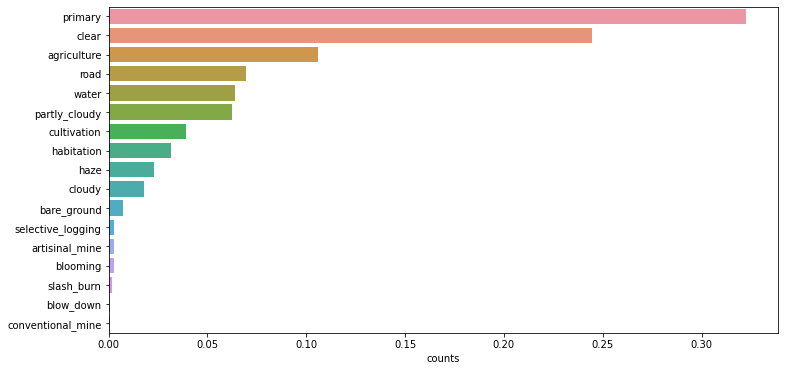

In [83]:
df_tags = pd.DataFrame(class_counters, index=[0]).T.rename(columns={0:'counts'}).sort_values('counts', ascending=False)
df_tags['counts'] = df_tags['counts']/len(tags)
_, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='counts', y=df_tags.index, data=df_tags, orient='h');

## Visualize image data

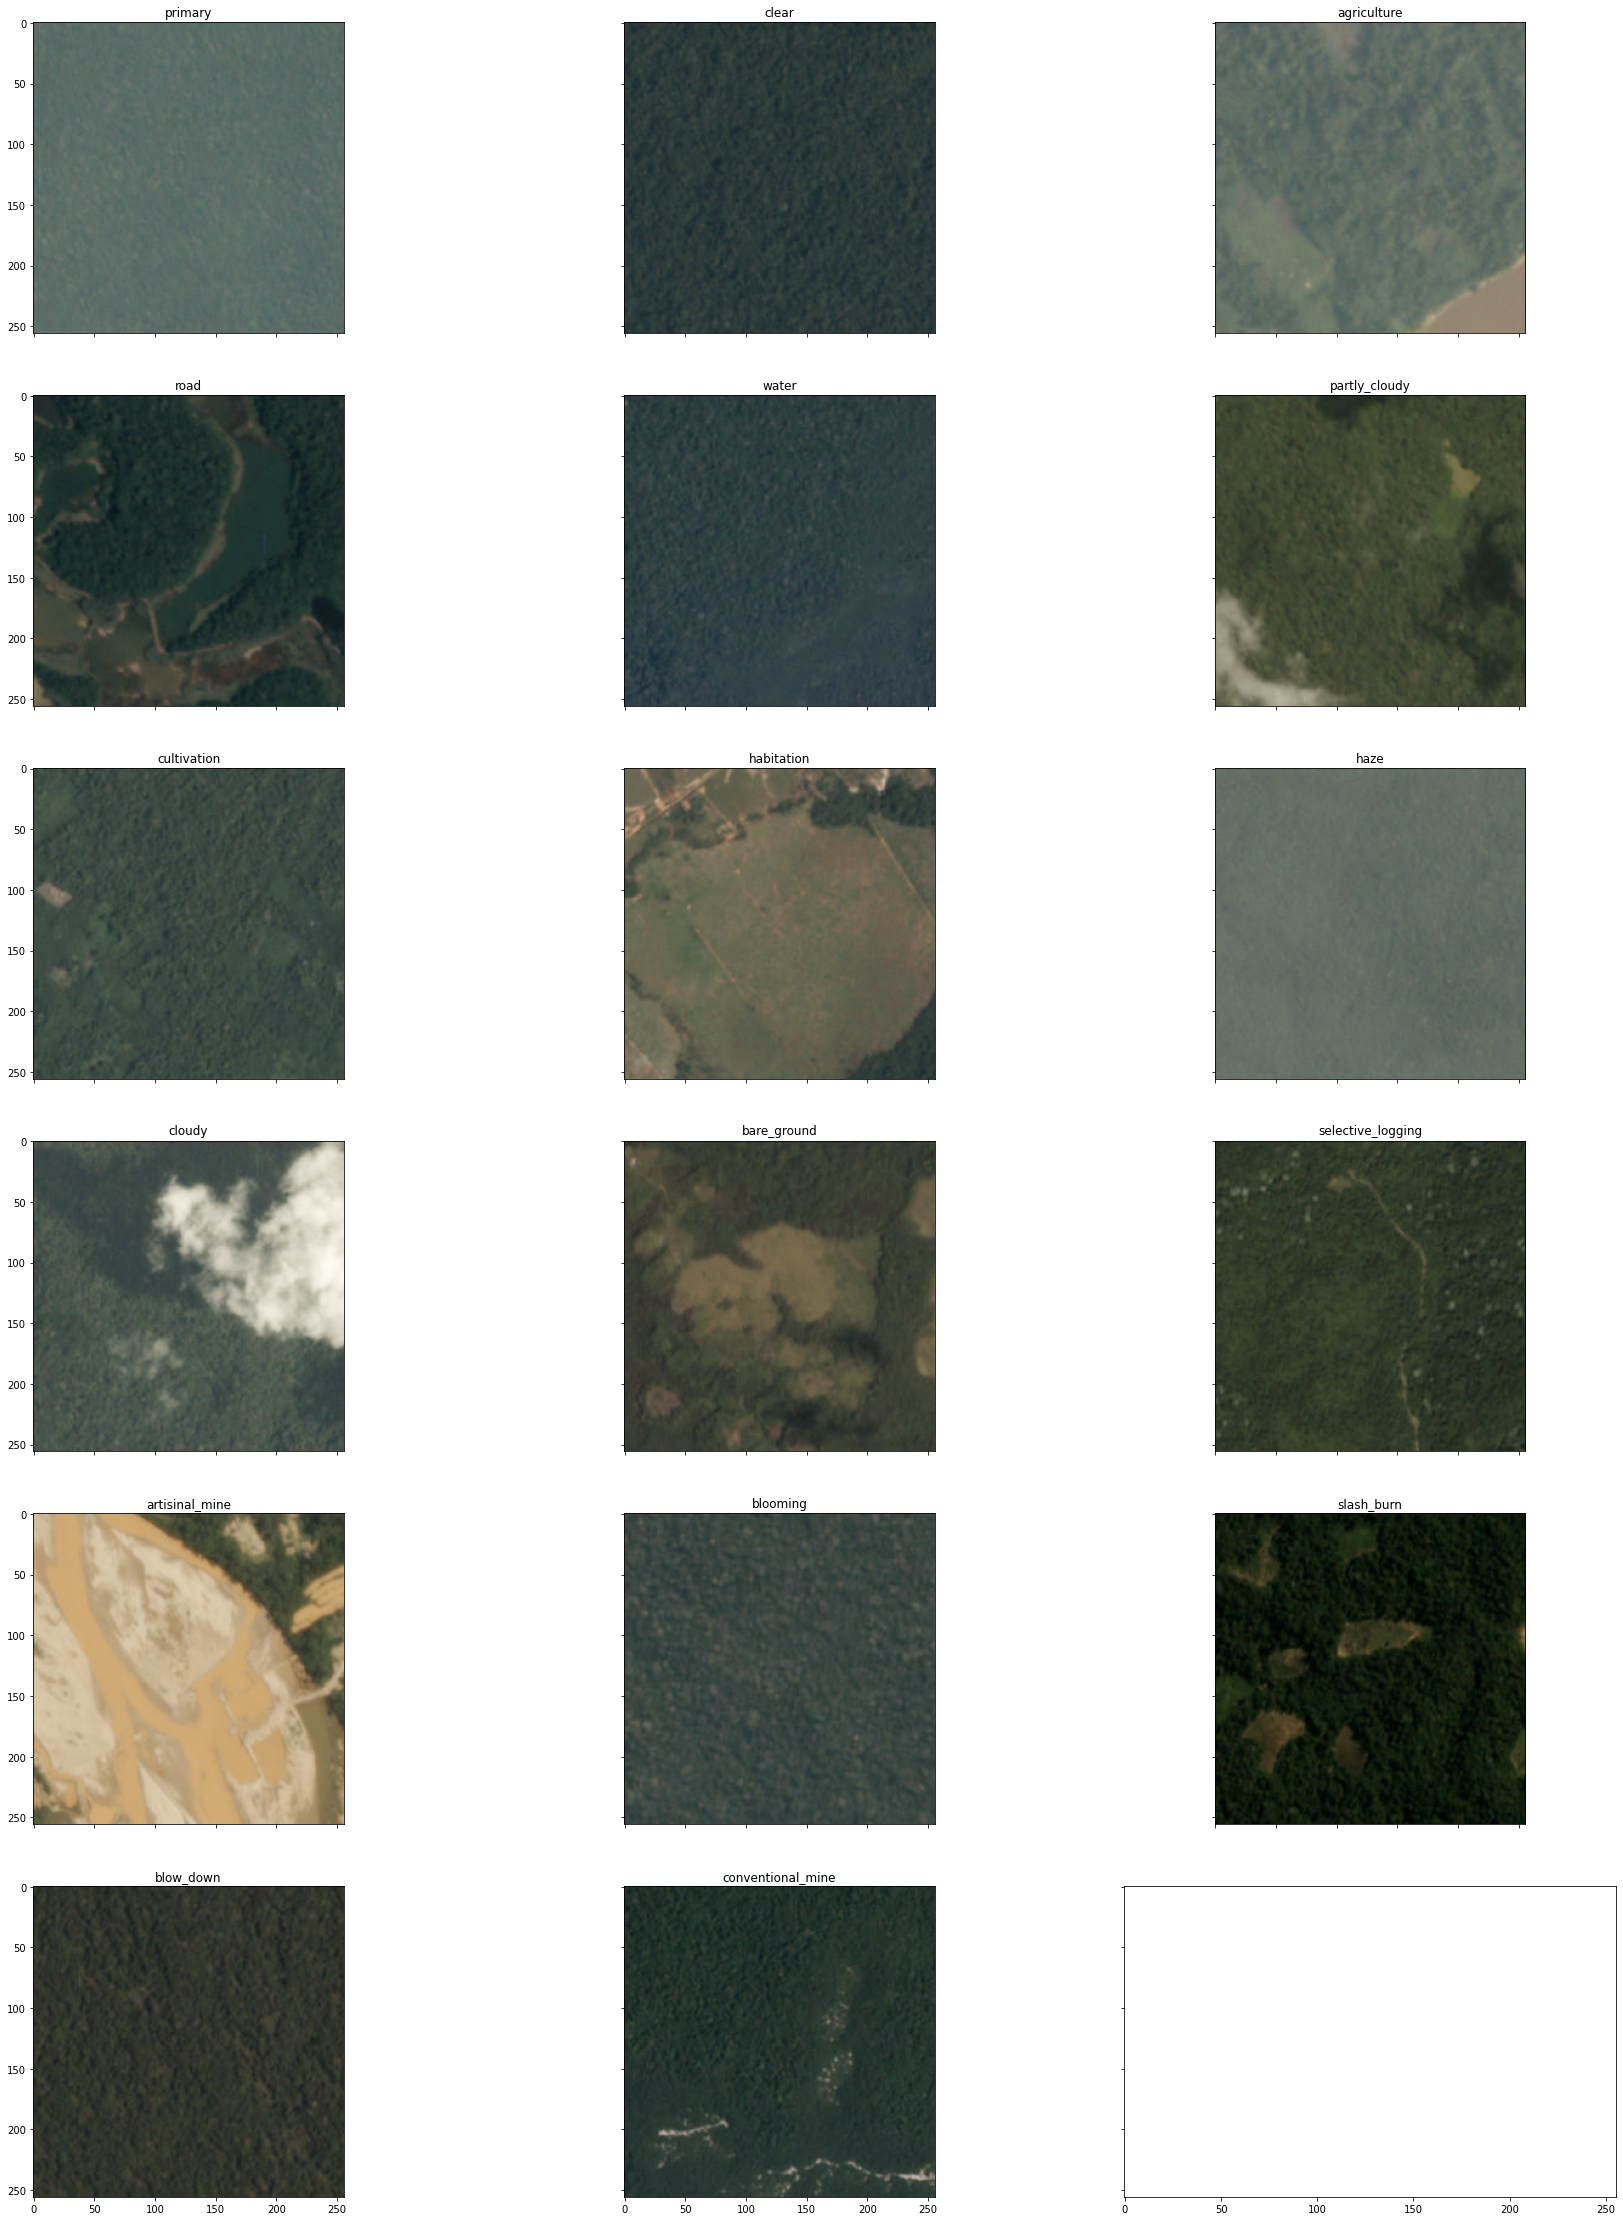

In [95]:
# find image name for each tag
image_names = [df_train[df_train['tags'].str.contains(label)].reset_index(drop=True).loc[i, 'image_name'] for i, label in enumerate(df_tags.index.tolist())]

plt.rc('axes',grid=False)
_, axes = plt.subplots(6, 3, sharex='col', sharey='row', figsize=(30, 40))
axes = axes.ravel()

for i, (image_name, label) in enumerate(zip(image_names, df_tags.index.tolist())):
  img = mpimg.imread(image_name)
  axes[i].imshow(img)
  axes[i].set_title(f'{label}')

## Encode the labels

As seen in the train data, each image contains more than one labels. So here we need to encode our labels that will be useful to train our model. We will use One-hot encoding for each label in each image. It means that the label for an image will be an array of lenght 17, all of which are zero but with some 1's in certain positions.

For example,

|Original label|Encoding label|
|---|---|
|[haze, primary]|[0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0]|



In [99]:
encoder = MultiLabelBinarizer()
targets = encoder.fit_transform(df_train['tag_list']).astype(float)

In [102]:
targets[:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
        0.],
       [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0.],
       [1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.,
        0.]])

## Split train and validation sets

In this case we have imbalanced dataset. In reality, we probably can combine some of the tags into one tag and make the data more balanced. But here, because we want to see the capibility of the model to make predictions on each tag, we will use all of tags to train our model. Also, we will ensure the distribution of each tag is consistent for both train and validation sets.


In [107]:
multilabel_skfold = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, val_idx in multilabel_skfold.split(df_train['image_name'], targets):
  X_train = df_train.loc[train_idx, 'image_name'].values
  X_val = df_train.loc[val_idx, 'image_name'].values
  y_train, y_val = targets[train_idx], targets[val_idx]

  print(y_train.sum(0))
  print(y_val.sum(0))
  print('\n')

[ 9852.   271.   690.   266.    78. 22765.  1671.    80.  3582.  2928.
  2158.  5809. 30010.  6456.   272.   168.  5929.]
[2463.   68.  172.   66.   20. 5666.  418.   20.  895.  732.  539. 1452.
 7503. 1615.   68.   41. 1482.]


[ 9852.   271.   689.   265.    79. 22761.  1671.    80.  3581.  2928.
  2158.  5808. 30010.  6457.   272.   167.  5928.]
[2463.   68.  173.   67.   19. 5670.  418.   20.  896.  732.  539. 1453.
 7503. 1614.   68.   42. 1483.]


[ 9852.   271.   690.   266.    78. 22743.  1671.    80.  3582.  2928.
  2157.  5809. 30010.  6457.   272.   167.  5929.]
[2463.   68.  172.   66.   20. 5688.  418.   20.  895.  732.  540. 1452.
 7503. 1614.   68.   42. 1482.]


[ 9852.   271.   689.   265.    79. 22741.  1671.    80.  3581.  2928.
  2157.  5809. 30011.  6457.   272.   167.  5929.]
[2463.   68.  173.   67.   19. 5690.  418.   20.  896.  732.  540. 1452.
 7502. 1614.   68.   42. 1482.]


[ 9852.   272.   690.   266.    78. 22714.  1672.    80.  3582.  2928.
  2158.  5809